# Comparing 184A1 model predictions to SBF2 model predictions

Predict VAE_all/CondVAE on SBF2 data and compare predicted CSLs with actual model. There should be little difference between the two models.

In [38]:
from campa.tl import Experiment, Predictor, Cluster
from campa.tl import (
    Cluster,
    Experiment,
    get_clustered_cells,
    load_full_data_dict,
    add_clustering_to_adata,
)
from campa.tl._cluster import annotate_clustering
from campa.data import MPPData
import os
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

from campa.constants import campa_config
from campa_ana.constants import SOURCE_DIR

In [2]:
fig_dir = Path(SOURCE_DIR)/'figures'/'fig5_suppl'
os.makedirs(str(fig_dir), exist_ok=True)

In [3]:
# load experiments and data dirs
exp_name_all = 'VAE_all/CondVAE_pert-CC'
exp_name_sbf2 = 'VAE_SBF2/CondVAE_siRNA-CC'
cluster_name_all = 'clustering_res0.5'
cluster_name_sbf2 = 'clustering_res0.9_sub-0.33_seed3'

exp_all = Experiment.from_dir(exp_name_all)
exp_sbf2 = Experiment.from_dir(exp_name_sbf2)
data_dirs = exp_sbf2.data_params['data_dirs']

print(data_dirs)

cl_all = Cluster.from_cluster_data_dir(os.path.join(exp_all.dir, exp_all.name, 'aggregated/sub-0.001'))
cl_all.set_cluster_name(cluster_name_all)

cl_sbf2 = Cluster.from_cluster_data_dir(os.path.join(exp_sbf2.dir, exp_sbf2.name, 'aggregated/sub-0.005_sub-0.33'))
cl_sbf2.set_cluster_name(cluster_name_sbf2)

example_mapobject_ids = {'HeLa_SBF2/K18': [256477], 'HeLa_scrambled/K19': [200942]}

['HeLa_SBF2/K18', 'HeLa_SBF2/L19', 'HeLa_SBF2/M18', 'HeLa_scrambled/K19', 'HeLa_scrambled/L18', 'HeLa_scrambled/M19']


In [4]:
# load mpp data for the two experiments
mpp_datas_all = load_full_data_dict(exp_all, data_dirs=['HeLa_SBF2/K18', 'HeLa_scrambled/K19'], save_dir = "aggregated_HeLa/full_data", 
                                          keys = ("x", "y", "obj_ids", cluster_name_all))
# ensure clustering is loaded as string
for name, mpp_data in mpp_datas_all.items():
    mpp_data._data[cluster_name_all] = mpp_data._data[cluster_name_all].astype(str)


mpp_datas_sbf2 = load_full_data_dict(exp_sbf2, data_dirs=['HeLa_SBF2/K18', 'HeLa_scrambled/K19'], 
                                           keys = ("x", "y", "obj_ids", cluster_name_sbf2))
# ensure clustering is loaded as string
for name, mpp_data in mpp_datas_sbf2.items():
    mpp_data._data[cluster_name_sbf2] = mpp_data._data[cluster_name_sbf2].astype(str)


In [5]:
# get cells to plot
def get_clustered_cells(mpp_datas, cluster_name, annotation, cluster_annotation, mapobject_ids):
    from campa.pl import annotate_img

    res = {cluster_name: {}, cluster_name + "_colored": {}}
    for data_dir, mpp_data in mpp_datas.items():
        if data_dir not in mapobject_ids.keys():
            continue
        print(data_dir)
        # get random obj_ids for this mpp_data
        #rng = np.random.default_rng(seed=42)
        #obj_ids = rng.choice(mpp_data.unique_obj_ids, num_objs, replace=False)
        obj_ids = mapobject_ids[data_dir]
        # subset mpp_data to obj_ids
        sub_mpp_data = mpp_data.subset(obj_ids=obj_ids, copy=True)
        
        # if only need colored cells, can pass annotation_kwargs to get_object_imgs
        res[cluster_name][data_dir] = sub_mpp_data.get_object_imgs(
            data=cluster_name
        )  # annotation_kwargs={'color': True, 'annotation': cl.cluster_annotation})
        res[cluster_name + "_colored"][data_dir] = [
            annotate_img(img, annotation=cluster_annotation, from_col=cluster_name, to_col=annotation, color=True)
            for img in res[cluster_name][data_dir]
        ]
    return res


In [6]:
example_cells = {}
example_cells.update(get_clustered_cells(mpp_datas_sbf2, 
                                         cluster_name=cluster_name_sbf2, annotation='annotation',
                                         cluster_annotation=cl_sbf2.cluster_annotation, mapobject_ids=example_mapobject_ids))
example_cells.update(get_clustered_cells(mpp_datas_all, 
                                         cluster_name=cluster_name_all, annotation='annotation',
                                         cluster_annotation=cl_all.cluster_annotation, mapobject_ids=example_mapobject_ids))

HeLa_SBF2/K18
HeLa_scrambled/K19
HeLa_SBF2/K18
HeLa_scrambled/K19


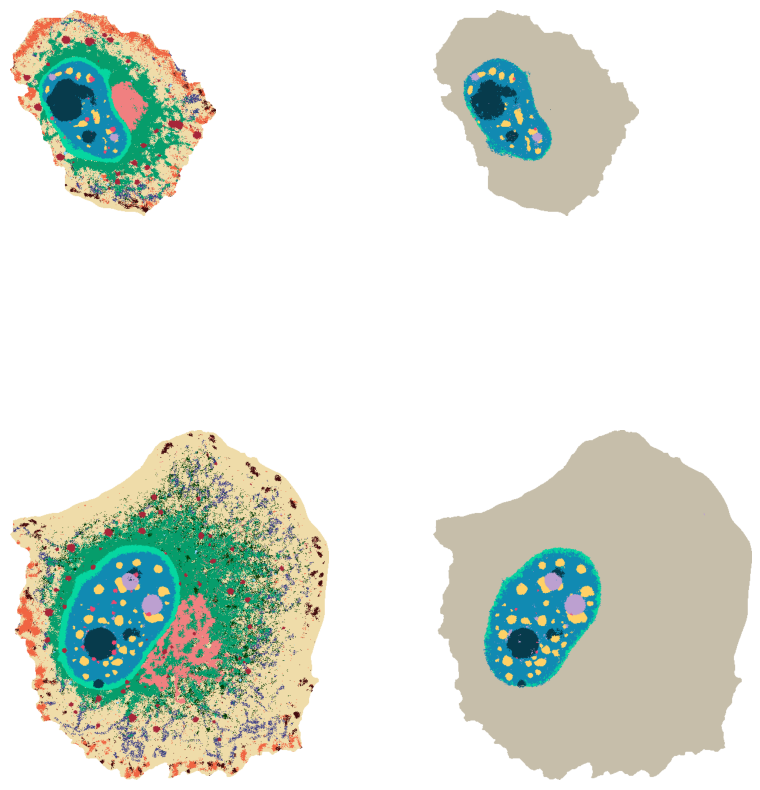

In [10]:
# plot example cells
fig, axes = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)
for i,data_dir in enumerate(list(example_mapobject_ids.keys())[::-1]):
    axes[i,0].imshow(example_cells['clustering_res0.9_sub-0.33_seed3_colored'][data_dir][0][::-1])
    axes[i,1].imshow(example_cells['clustering_res0.5_colored'][data_dir][0][::-1])
for ax in axes.flat:
    ax.axis('off')
plt.savefig(fig_dir / 'example_cells_184A1_on_HeLa.png', dpi=300)

In [16]:
def compute_cluster_overlap(mpp_datas_sbf2, mpp_datas_all):
    # define clusters that we can compare
    labels = ['Cajal bodies', 'Nuclear periphery',
           'Nuclear speckles', 'Nucleolus', 'Nucleoplasm', 'PML bodies']

    intersections = {}
    unions = {}
    for data_dir in mpp_datas_all.keys():

        clustering_sbf2 = annotate_clustering(mpp_datas_sbf2[data_dir].data(cluster_name_sbf2), 
                                              annotation=cl_sbf2.cluster_annotation,
                                              cluster_name=cluster_name_sbf2,
                                              annotation_col='annotation')
        clustering_all = annotate_clustering(mpp_datas_all[data_dir].data(cluster_name_all), 
                                              annotation=cl_all.cluster_annotation,
                                              cluster_name=cluster_name_all,
                                              annotation_col='annotation')  
        # restrict comparison to only nucleus
        mask = clustering_all != 'Extra-nuclear'
        intersections[data_dir] = {}
        unions[data_dir] = {}
        for l in labels:
            mask_all = clustering_all[mask] == l
            mask_sbf2 = clustering_sbf2[mask] == l
            intersections[data_dir][l] = np.sum(mask_all & mask_sbf2)
            unions[data_dir][l] = np.sum(mask_all | mask_sbf2)
    return pd.DataFrame(intersections), pd.DataFrame(unions)

In [17]:
# compute stats for cluster overlap
intersections, unions = compute_cluster_overlap(mpp_datas_sbf2, mpp_datas_all)

In [19]:
# get cluster overlap for remaining wells as well
# load mpp data for the two experiments
mpp_datas_all = load_full_data_dict(exp_all, data_dirs=['HeLa_SBF2/L19', 'HeLa_scrambled/L18'], save_dir = "aggregated_HeLa/full_data", 
                                          keys = ("x", "y", "obj_ids", cluster_name_all))
# ensure clustering is loaded as string
for name, mpp_data in mpp_datas_all.items():
    mpp_data._data[cluster_name_all] = mpp_data._data[cluster_name_all].astype(str)


mpp_datas_sbf2 = load_full_data_dict(exp_sbf2, data_dirs=['HeLa_SBF2/L19', 'HeLa_scrambled/L18'], 
                                           keys = ("x", "y", "obj_ids", cluster_name_sbf2))
# ensure clustering is loaded as string
for name, mpp_data in mpp_datas_sbf2.items():
    mpp_data._data[cluster_name_sbf2] = mpp_data._data[cluster_name_sbf2].astype(str)

intersections2, unions2 = compute_cluster_overlap(mpp_datas_sbf2, mpp_datas_all)

In [20]:
# get cluster overlap for remaining wells as well
# load mpp data for the two experiments
mpp_datas_all = load_full_data_dict(exp_all, data_dirs=['HeLa_SBF2/M18', 'HeLa_scrambled/M19'], save_dir = "aggregated_HeLa/full_data", 
                                          keys = ("x", "y", "obj_ids", cluster_name_all))
# ensure clustering is loaded as string
for name, mpp_data in mpp_datas_all.items():
    mpp_data._data[cluster_name_all] = mpp_data._data[cluster_name_all].astype(str)


mpp_datas_sbf2 = load_full_data_dict(exp_sbf2, data_dirs=['HeLa_SBF2/M18', 'HeLa_scrambled/M19'], 
                                           keys = ("x", "y", "obj_ids", cluster_name_sbf2))
# ensure clustering is loaded as string
for name, mpp_data in mpp_datas_sbf2.items():
    mpp_data._data[cluster_name_sbf2] = mpp_data._data[cluster_name_sbf2].astype(str)

intersections3, unions3 = compute_cluster_overlap(mpp_datas_sbf2, mpp_datas_all)

In [24]:
unions = pd.concat((unions, unions2, unions3), axis=1)
intersections = pd.concat((intersections, intersections2, intersections3), axis=1)

In [29]:
(intersections / unions)

,HeLa_SBF2/K18,HeLa_scrambled/K19,HeLa_SBF2/L19,HeLa_scrambled/L18,HeLa_SBF2/M18,HeLa_scrambled/M19
Cajal bodies,0.723807,0.651826,0.751720,0.694151,0.747742,0.657603
Nuclear periphery,0.294400,0.045434,0.040853,0.021561,0.155762,0.034763
Nuclear speckles,0.732920,0.475269,0.515466,0.237939,0.522520,0.362021
Nucleolus,0.789981,0.776078,0.778262,0.764801,0.759906,0.755255
Nucleoplasm,0.801609,0.633647,0.729889,0.627071,0.774448,0.655766
PML bodies,0.276510,0.367651,0.317771,0.318667,0.297607,0.299716


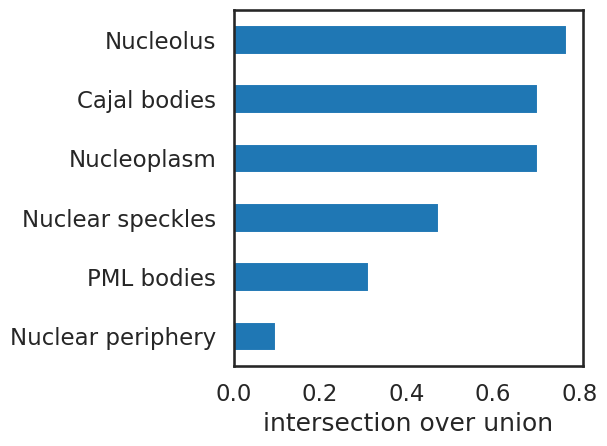

In [44]:
# save plot
sns.set_style('white')
sns.set_context('talk')
((intersections / unions).mean(axis=1)).sort_values().plot(kind='barh', xlabel='intersection over union')
plt.tight_layout()
plt.savefig(fig_dir / 'iou_184A1_on_HeLa.png', dpi=300)